In [82]:
from textattack.augmentation import WordNetAugmenter, EmbeddingAugmenter, EasyDataAugmenter, CharSwapAugmenter, BackTranslationAugmenter
import warnings
import torch
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from typing import List, Literal, Union
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /Users/opop/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
prompt = "I am an example, we will explore textattack's augmentation capabilities with me."

In [3]:
wn_aug = WordNetAugmenter()
emb_aug = EmbeddingAugmenter()
bt_aug = BackTranslationAugmenter()
easy_aug = EasyDataAugmenter()
char_aug = CharSwapAugmenter()

[nltk_data] Downloading package omw-1.4 to /Users/opop/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/opop/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
wn_augmented_text = wn_aug.augment(prompt)
emb_augmented_text = emb_aug.augment(prompt)
easy_augmented_text = easy_aug.augment(prompt)
char_augmented_text = char_aug.augment(prompt)
bt_augmented_text = bt_aug.augment(prompt)

print(f"Original: {prompt}")
print(f"WordNetAugmenter: {wn_augmented_text[0]}")
print(f"EmbeddingAugmenter: {emb_augmented_text[0]}")
print(f"EasyDataAugmenter: {easy_augmented_text[0]}")
print(f"CharSwapAugmenter: {char_augmented_text[0]}")
print(f"BackTranslationAugmenter: {bt_augmented_text[0]}")

Original: I am an example, we will explore textattack's augmentation capabilities with me.
WordNetAugmenter: iodine am an example, we will explore textattack's augmentation capabilities with me.
EmbeddingAugmenter: I am an example, we will explore textattack's widen capabilities with me.
EasyDataAugmenter: I am an example, we will explore augmentation capabilities with me.
CharSwapAugmenter: I am an example, we will explore textattack's augmentation oapabilities with me.
BackTranslationAugmenter: I'm a copy, exploring the ability to increase testosterone with me.


Le problème du package `textattack` c'est qu'il n'y a pas autant d'options par rapport à `nlpaug`, de plus sur certaines méthodes on ne nous laisse pas beaucoup de choix sur les modèles

`nlpaug` offre de nombreuses méthode pour augmenter le texte, incluant celles vu ci-dessus. Ici, nous allons nous intéresser à l'augmentation via des modèles d'embeddings.

In [10]:
import nlpaug.augmenter.word as naw # type: ignore

In [16]:
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased',
                                device='cpu',
                                action='substitute')

In [19]:
print(f"Original: {prompt}")
print(f"nlpaug: {aug.augment(prompt)[0]}")

Original: I am an example, we will explore textattack's augmentation capabilities with me.
nlpaug: i pursued their example, we would explore textattack'latest augmentation route through me.


Maintenant nous allons récupérer les données undersamplées afin de les augmenter

In [51]:
data_train = pd.read_csv('../../data/train_under.csv')
data_val = pd.read_csv('../../data/val_under.csv')

In [52]:
data_train.head()

,corrected_text,length,ratio_err,labels
0,the author supports the idea that studying ven...,403,0.000000,3
1,driverless cars are important improvement tech...,420,0.004762,4
2,intro this new facial software could the next ...,545,0.022018,4
3,belive thate the face just natural landform be...,287,0.038328,2
4,against driverless cars because isn really dri...,266,0.011278,2


In [53]:
data_val.head()

,corrected_text,length,ratio_err,labels
0,the reason have not got venus yet because all ...,340,0.041176,2
1,imagine you are doing school work and gets bor...,291,0.006873,3
2,the authors supporting details pretty well the...,190,0.026316,2
3,when don came and asked europe was glad that s...,217,0.036866,2
4,fellow citizens important that talk about the ...,604,0.011589,1


Il y a plusieurs paramètres qu'il faut prendre en compte lors de l'oversampling:  
- Les erreurs étant corrigées, on aura des `NaN`au niveau de `ratio_err`, comment gérer ça ?  
    *On peut soit décider d'utiliser un imputer (comme la médiane), soit juste associer la valeure du texte modifié,
    le but étant de conserver un maximum la distribution originelle pour chaque label*
- Comment éviter les redondances ?   
    *Il y a plusieurs paramètres qu'on peut modifier pour les éviter, une autre approche serait d'utiliser plusieurs augmenteurs*

In [72]:
def augmentation_pipeline(df: pd.DataFrame, 
                          col: str, 
                          augmenter_model: str,
                          action: Literal['substitute', 'insert', 'swap', 'delete'],
                          inputer: Literal['source', 'median', 'mean'], 
                          **kwargs) -> pd.DataFrame:
    """
    Augment the data using the specified augmenter model.

    Args:
        df {pd.DataFrame} -- The DataFrame to augment
        col {str} -- The column to augment
        augmenter_model {str} -- The model to use for augmentation
        action {Literal['substitute', 'insert', 'swap', 'delete']} -- The action to perform
        inputer {Literal['source', 'median', 'mean']} -- The method to input the missing values
            source: Use the original value of the random row
            median: Use the median value of the column
            mean: Use the mean value of the column
        kwargs -- Additional arguments for the augmenter model

    Returns:
        pd.DataFrame -- The augmented DataFrame
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"

    augmenter = naw.ContextualWordEmbsAug(model_path=augmenter_model, 
                                          device=device, 
                                          action=action,
                                          **kwargs)
    
    max_count = df['labels'].value_counts().max()
    
    augmentation_counts = df['labels'].value_counts().apply(lambda x: max_count - x)
    
    augmented_data = []
    
    for i, (label, count) in tqdm(enumerate(augmentation_counts.items()), desc='Augmenting data', total=len(augmentation_counts)):
        if count > 0:
            label_data = df[df['labels'] == label]
            
            for _ in range(count):
                row = label_data.sample(n=1, random_state=i, replace=True).iloc[0]
                original_text = row[col]
                augmented_text = augmenter.augment(original_text)[0]
                
                new_row = row.copy()
                new_row[col] = augmented_text
                new_row['is_generated'] = 1 
                new_row['length'] = len(nltk.word_tokenize(augmented_text))  

                if inputer == 'source':
                    new_row['ratio_err'] = row['ratio_err']
                
                augmented_data.append(new_row)
    
    augmented_df = pd.DataFrame(augmented_data)
    
    if inputer == 'mean':
        mean_value = df['ratio_err'].mean()
        augmented_df['ratio_err'].fillna(mean_value, inplace=True)
    elif inputer == 'median':
        median_value = df['ratio_err'].median()
        augmented_df['ratio_err'].fillna(median_value, inplace=True)
    
    df['is_generated'] = 0  
    final_df = pd.concat([df, augmented_df], ignore_index=True)
    
    return final_df

In [73]:
sample_df = data_train.sample(n=40, random_state=42)

In [74]:
sample_df['labels'].value_counts()

labels
3    12
2     9
4     7
1     7
5     5
Name: count, dtype: int64

In [85]:
sample_df.head()

,corrected_text,length,ratio_err,labels,is_generated
5953,the years seem flying people seem growing smar...,598,0.001672,5,0
2481,exploring venus challenge and studying this pl...,399,0.005013,4,0
286,highly suggested that the electoral college sh...,346,0.005780,3,0
7469,according the passage using emotions and expre...,183,0.000000,1,0
8092,the author suggests that studying venus worthy...,250,0.052000,1,0


In [96]:
new_sample_df = augmentation_pipeline(
    sample_df,
    'corrected_text',
    'distilbert-base-uncased',
    'substitute',
    'source',
    top_k=20,  
    aug_p=0.3
)                                

Augmenting data:   0%|          | 0/5 [00:00<?, ?it/s]

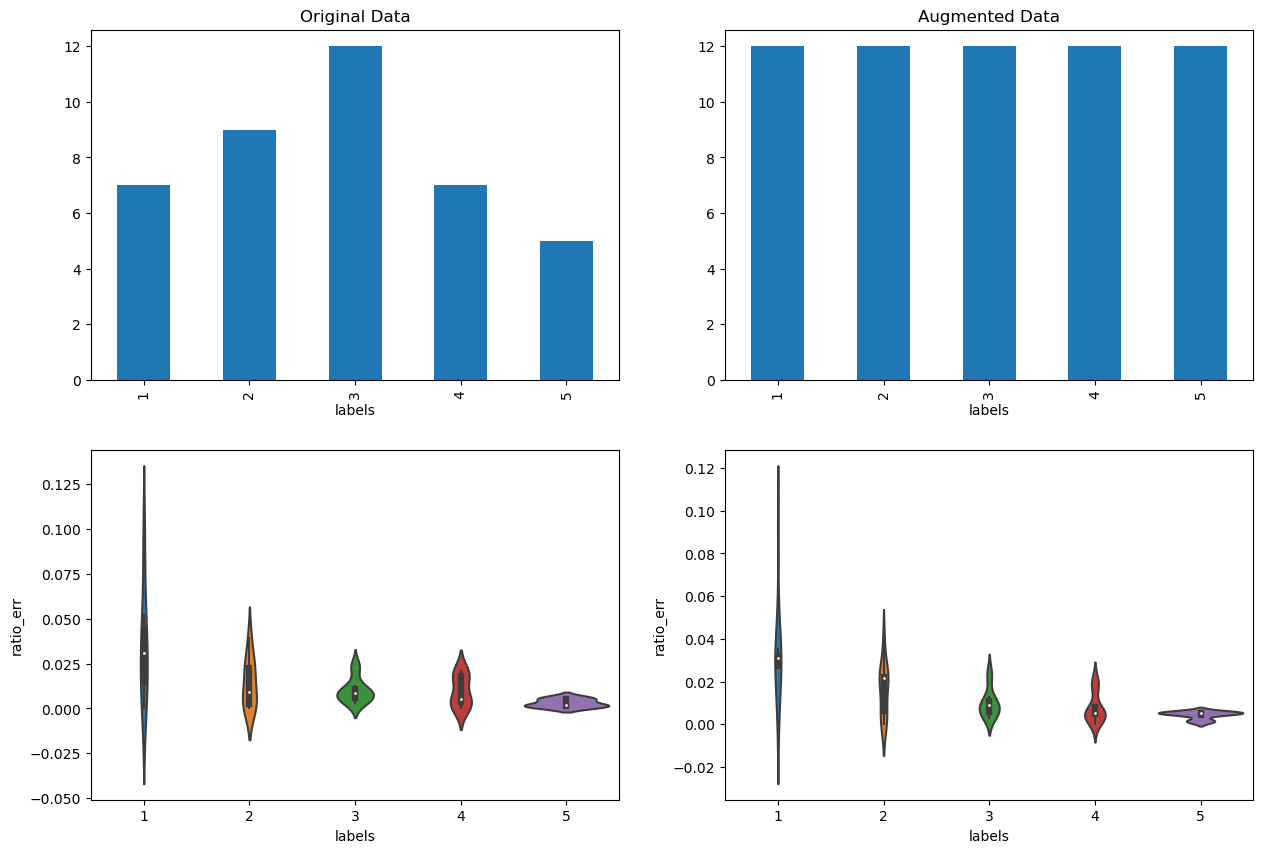

In [97]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

values_or= sample_df['labels'].value_counts().sort_index()
values_or.plot(kind='bar', ax=ax[0, 0])
ax[0, 0].set_title('Original Data')

values_gen = new_sample_df['labels'].value_counts().sort_index()
values_gen.plot(kind='bar', ax=ax[0, 1])
ax[0, 1].set_title('Augmented Data')

sns.violinplot(x='labels', y='ratio_err', data=sample_df, ax=ax[1, 0])

sns.violinplot(x='labels', y='ratio_err', data=new_sample_df, ax=ax[1, 1])

plt.show()